# データセットクラスを書いてみよう

ここでは、Chainerにすでに用意されているCIFAR10のデータを取得する機能を使って、データセットクラスを自分で書いてみます。Chainerでは、データセットを表すクラスは以下の機能を持っていることが必要とされます。

- データセット内のデータ数を返す`__len__`メソッド
- 引数として渡される`i`に対応したデータもしくはデータとラベルの組を返す`get_example`メソッド

その他のデータセットに必要な機能は、`chainer.dataset.DatasetMixin`クラスを継承することで用意できます。ここでは、`DatasetMixin`クラスを継承し、Data augmentation機能のついたデータセットクラスを作成してみましょう。

## 1. CIFAR10データセットクラスを書く

In [1]:
import numpy as np
from chainer import dataset
from chainer.datasets import cifar

gpu_id = 0  # Set to -1 if you don't have a GPU

class CIFAR10Augmented(dataset.DatasetMixin):

    def __init__(self, train=True):
        train_data, test_data = cifar.get_cifar10()
        if train:
            self.data = train_data
        else:
            self.data = test_data
        self.train = train
        self.random_crop = 4

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        x, t = self.data[i]
        if self.train:
            x = x.transpose(1, 2, 0)
            h, w, _ = x.shape
            x_offset = np.random.randint(self.random_crop)
            y_offset = np.random.randint(self.random_crop)
            x = x[y_offset:y_offset + h - self.random_crop,
                  x_offset:x_offset + w - self.random_crop]
            if np.random.rand() > 0.5:
                x = np.fliplr(x)
            x = x.transpose(2, 0, 1)
        return x, t

このクラスは、CIFAR10のデータのそれぞれに対し、

- 32x32の大きさの中からランダムに28x28の領域をクロップ
- 1/2の確率で左右を反転させる

という加工を行っています。こういった操作を加えることで擬似的に学習データのバリエーションを増やすと、オーバーフィッティングを抑制することに役に立つということが知られています。これらの操作以外にも、画像の色味を変化させるような変換やランダムな回転、アフィン変換など、さまざまな加工によって学習データ数を擬似的に増やす方法が提案されています。

## 2. 作成したデータセットクラスを使って学習を行う

それではさっそくこの`CIFAR10`クラスを使って学習を行ってみましょう。先程使ったのと同じ大きなネットワークを使うことで、Data augmentationの効果がどの程度あるのかを調べてみましょう。`train`関数も含め、データセットクラス以外は先程使用したコードとほぼ同じになっています。異なるところはエポック数と、保存先ディレクトリ名だけです。

In [2]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

class ConvBlock(chainer.Chain):
    
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w)
            self.bn = L.BatchNormalization(n_ch)
        
        
        self.pool_drop = pool_drop
        
    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):
    
    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(None, 1024, initialW=w)
        
    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5)
    
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        
    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x

def train(model_object, batchsize=64, gpu_id=gpu_id, max_epoch=20):

    # 1. Dataset
    train, test = CIFAR10Augmented(), CIFAR10Augmented(False)

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id >= 0:
            model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10augmented_result'.format(model_object.__class__.__name__))

    # 7. Evaluator

    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            ret = super(TestModeEvaluator, self).evaluate()
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer
    
    return model
    
model = train(DeepCNN(10), max_epoch=100, gpu_id=gpu_id)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           2.00001     0.256014       1.57511               0.387042                  22.3491       
2           1.52671     0.425636       1.40038               0.519904                  41.2664       
3           1.28287     0.536952       1.15701               0.604498                  60.5042       
4           1.08604     0.622219       0.944904              0.68123                   80.1142       
5           0.942842    0.683084       0.842809              0.72074                   100.876       
6           0.816785    0.731034       0.714509              0.773089                  121.763       
7           0.722347    0.764625       0.667309              0.780354                  143.043       
8           0.658298    0.78239        0.582964              0.802249                  164.356       
9           0.599204    0.802709       0.578796              0.806131               

先程のData augmentationなしの場合は87%程度で頭打ちになっていた精度が、学習データにaugmentationを施すことで89%以上まで向上させられることが分かりました。2%強の改善です。

最後に、ロスと精度のグラフを見てみましょう。

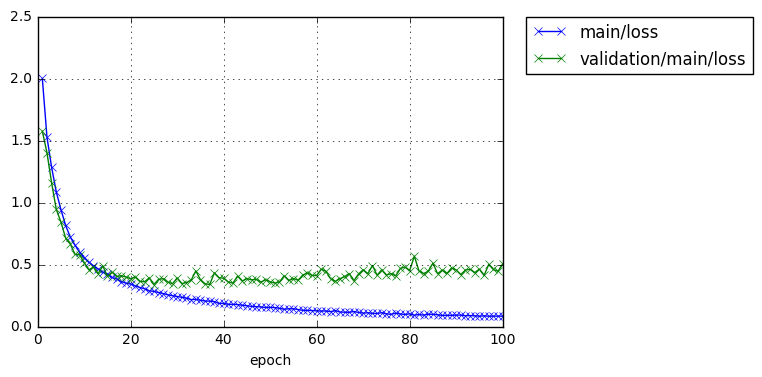

In [3]:
from IPython.display import Image
Image(filename='DeepCNN_cifar10augmented_result/loss.png')

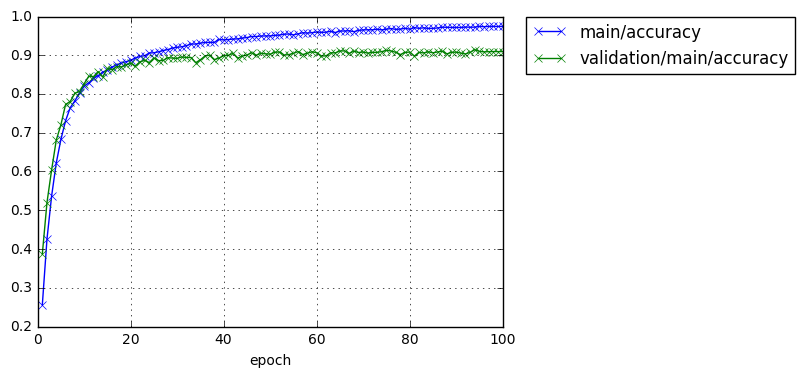

In [4]:
Image(filename='DeepCNN_cifar10augmented_result/accuracy.png')